100%|██████████| 1000/1000 [00:08<00:00, 114.77it/s]


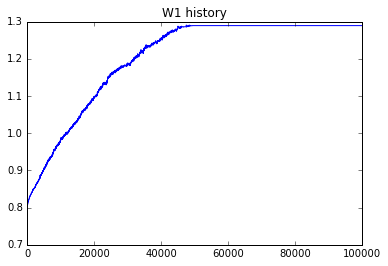

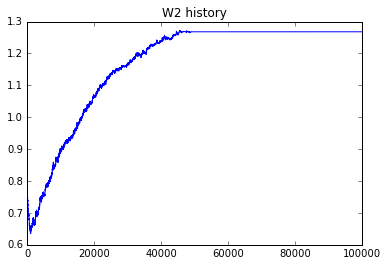

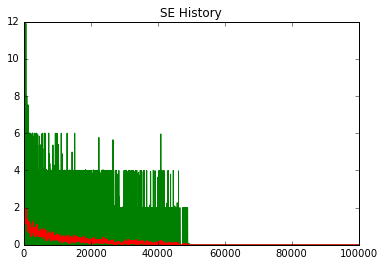

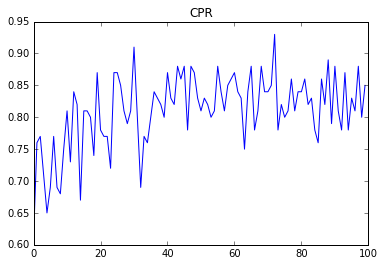

In [1]:
# This file is part of "MPS Yokohama Deep Learning Series Day 08/06/2016"
#
# "MPS Yokohama Deep Learning Series Day 08/06/2016"
# is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# "MPS Yokohama Deep Learning Series Day 08/06/2016"
# is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Foobar.  If not, see <http://www.gnu.org/licenses/>.
#
# (c) Junya Kaneko <jyuneko@hotmail.com>


import numpy as np
from matplotlib import pyplot as plt
# from matplotlib import *
from tqdm import tqdm
from layers import TanhLayer, se, d_se
from helpers import ma

if __name__ == '__main__':
    %matplotlib inline
    from mnist import MNIST

    # Load MNIST dataset
    mndata = MNIST('./mnist')
    train_img, train_label = mndata.load_training()
    train_img = np.array(train_img, dtype=float)/255.0
    train_label = np.array(train_label, dtype=float)

    # Input vector (Layer 0)
    n_output_0 = len(train_img[0])

    # Middle layer (Layer 1)
    n_output_1 = 200
    layer1 = TanhLayer(n_output_1, n_output_0)

    # Output layer (Layer 2)
    n_output_2 = 10
    layer2 = TanhLayer(n_output_2, n_output_1)

    # FP, BP and learning
    epsilon = 0.15
    n_training_data = 1000
    se_history = []
    y1_history = []
    y2_history = []
    W1_history = []
    W2_history = []
    cpr_history = []
    for loop in range(100):
        for i in tqdm(range(n_training_data)):
            # Store W1 and W2 history
            W1_history.append(np.average(np.abs(layer1._W)))
            W2_history.append(np.average(np.abs(layer2._W)))

            # FP
            x = train_img[i].reshape(len(train_img[i]), 1)
            y1 = layer1.propagate_forward(x)
            y2 = layer2.propagate_forward(y1)

            # Store y1 and y2
            y1_history.append(y1)
            y2_history.append(y2)

            # Training datum
            t = np.zeros(shape=(10, 1))
            t.fill(-1.0)
            t[train_label[i], 0] = 1.0

            # Calculate and store SE
            se_history.append(se(t, y2))

            # BP
            delta2 = layer2.propagate_backward(d_se(t, y2), None)
            delta1 = layer1.propagate_backward(delta2, layer2.W)

            # Learning
            layer2.update(layer1.y, epsilon)
            layer1.update(x, epsilon)

        # FP to evaluate correct prediction rate
        n_correct_prediction = 0
        n_prediction = 0
        for _i in np.random.choice(np.arange(n_training_data, train_img.shape[0]), 100):
            _x = train_img[_i].reshape(len(train_img[_i]), 1)
            _y1 = layer1.propagate_forward(_x)
            _y2 = layer2.propagate_forward(_y1)

            n_prediction += 1
            if train_label[_i] == np.argmax(_y2):
                n_correct_prediction += 1
        cpr_history.append(n_correct_prediction/n_prediction)

    # Draw W1
    plt.figure()
    plt.title('W1 history')
    plt.plot(range(len(W1_history)), W1_history)
    plt.savefig('img_mnist_tanh/w1_history.png')

    # Draw W2
    plt.figure()
    plt.title('W2 history')
    plt.plot(range(len(W2_history)), W2_history)
    plt.savefig('img_mnist_tanh/w2_history.png')

    # Draw SE history and its moving average
    plt.figure()
    plt.title('SE History')
    plt.plot(range(len(se_history)), se_history, color='green')
    plt.plot(range(len(se_history)), ma(se_history, 100), color='red')
    plt.savefig('img_mnist_tanh/se_history.png')

    # Draw CPR history
    plt.figure()
    plt.title('CPR')
    plt.plot(range(len(cpr_history)), cpr_history)
    plt.savefig('img_mnist_tanh/cpr.png')

    plt.show()